In [1]:
import os 
import sys
import json
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ast
sys.path.append('./models/')
from useful_functions import df_to_dict, concat_dico, get_classement, sort_list
from evaluate_model import WIS


In [2]:
models1Dnames=['Moving Average','ARIMA', 'Exponential', 'Linear Regression', 'Bayesian Regression','SIRH1', 'SIRH2', 'SIRH3', 'SIRH4']
models3Dnames=[ 'VAR', 'Exponential Multi', 'SIRH Multi1', 'SIRH Multi2','SEIR Mob']
ens_names=['EnsAvg','EnsMedian','EnsRegr','EnsRMSE','EnsWIS','EnsRank']
reach=14
list_of_models= models1Dnames+models3Dnames
print(list_of_models)

['Moving Average', 'ARIMA', 'Exponential', 'Linear Regression', 'Bayesian Regression', 'SIRH1', 'SIRH2', 'SIRH3', 'SIRH4', 'VAR', 'Exponential Multi', 'SIRH Multi1', 'SIRH Multi2', 'SEIR Mob']


In [3]:
def classify_bis(point, r_effs):  # Classification based on transmission dynamics

    if r_effs[point] < 0.5:
        return 'minimal transmission'
    elif r_effs[point] < 0.8:
        return 'low transmission'
    elif r_effs[point] < 1.2:
        return 'stable'
    elif r_effs[point] < 3:
        return 'high transmission'
    else:
        return 'very high transmission'

In [4]:
def safe_eval(x):
    replacement_value = [(0.0, 0.0)] * 11
    try:
        if isinstance(x, str):
            # Convert the string representation to an actual Python object
            evaluated = ast.literal_eval(x)

            # Check for (-inf, inf) tuples and replace with a default value (e.g., (0, 0))
            evaluated = [(0, 0) if (tup == (-np.inf, np.inf)) else tup for tup in evaluated]

            return evaluated
        else:
            return x
    except (ValueError, SyntaxError):
        return replacement_value  # Return None for invalid entries

In [5]:
#Define quantiles and weights
alphas=np.array([0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
weights=np.concatenate((np.array([0.5]), alphas * 0.5))
    
#Create training and test data
pointpred_train=pd.DataFrame(columns =[name for name in  list_of_models + ['Real values']])
pointpred_test=pd.DataFrame(columns =[name for name in  list_of_models + ['Real values']])
quant_train=pd.DataFrame(columns =[name for name in  list_of_models])
quant_test=pd.DataFrame(columns =[name for name in  list_of_models])

names = [name for name in os.listdir('./results/predictions_of_the_models/') if 's_'+str(reach) in name if 'predictions' in name]
names_train=[]
names_test=[]
np.random.seed(0)
for name in names: 

    prediction=pd.read_csv('./results/predictions_of_the_models/'+name)
    prediction.drop(['Unnamed: 0'], axis=1, inplace=True)
    prediction.index=[20 * i for i in range(1, 15)]
    quants=pd.read_csv('./results/predictions_of_the_models/'+name.replace('predictions','quantiles'))
    quants=quants.applymap(safe_eval)
    quants.drop(['Unnamed: 0'], axis=1, inplace=True)
    quants.index=[20 * i for i in range(1, 15)]
    
    
    if np.random.rand() < 0.5:#0.2 : #0.8 
        names_train.append(name)
        pointpred_train=pd.concat([pointpred_train, prediction])
        quant_train=pd.concat([quant_train, quants])
    else :
        names_test.append(name)
        pointpred_test=pd.concat([pointpred_test, prediction])
        quant_test=pd.concat([quant_test, quants])
        
matrix_train=np.array(pointpred_train)
matrix_test=np.array(pointpred_test)

X_train=matrix_train[:,:-1]
y_train=matrix_train[:,-1]
X_test=matrix_test[:,:-1]
y_test=matrix_test[:,-1]

#Replace outlier predictions with MA-predictions
for i in range(X_train.shape[0]):
    ma_pred=np.max(X_train[i,0])
    inds=np.where(np.abs(X_train[i,:])>1e6)
    X_train[i,inds]=ma_pred
for i in range(X_test.shape[0]):
    ma_pred=np.max(X_test[i,0])
    inds=np.where(np.abs(X_test[i,:])>1e6)
    X_test[i,inds]=ma_pred

/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/2856897532.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  quants=quants.applymap(safe_eval)
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/2856897532.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pointpred_test=pd.concat([pointpred_test, prediction])
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/2856897532.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  quants=quants.applymap(safe_eval)
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/2856897532.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.

In [6]:
#1: Ensemble with equal weights, quantiles given by mean
EnsW1=(1/len(list_of_models))*np.ones(len(list_of_models))
Inter1=0

In [7]:
#2: Ensemble with quantiles given by the median of forecast quantiles
EnsW2=(1/len(list_of_models))*np.ones(len(list_of_models))
Inter2=0
#Defined below

In [8]:
#3: #Ensemble weights obtained using linear regression, no constraints

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

R2 :  0.946751317053968
Coefficients :  [-0.34445083  0.08929448  0.18288352 -0.00156044  0.00649102  0.05764014
 -0.15046228 -0.20990698  0.31000953  0.23523707 -0.00094642  0.41341118
  0.00364642  0.15549225]
Intercept :  339.8525989431955


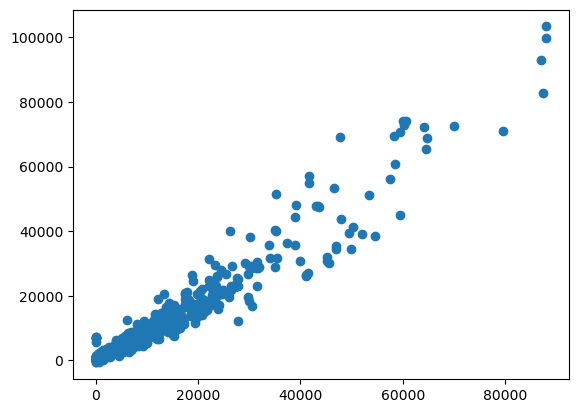

0.7467786672961034


In [9]:
regressor=LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print('R2 : ', r2_score(y_test, y_pred))
print('Coefficients : ', regressor.coef_)
print('Intercept : ', regressor.intercept_)
plt.plot(y_test, y_pred, 'o')
plt.show()
print(np.sum(regressor.coef_))
coefs=regressor.coef_
intercept=regressor.intercept_

EnsW3=coefs
Inter3=intercept

In [10]:
#Ensemble weights optimised wrt MSE with constraint sum(w)=1
def MSE_loss(w, X, y):
    predictions = X @ w
    mse = np.mean((y - predictions) ** 2)
    return mse

def constraint(w):
    return np.sum(w) - 1

In [11]:
# Define constraints and bounds
constraints = {'type': 'eq', 'fun': constraint}  # Equality constraint
bounds = [(0, None) for _ in range(X_train.shape[1])]  # Optional: Non-negative weights
# Initial guess
initial_w = np.ones(X_train.shape[1]) / X_train.shape[1]  # Start with equal weights
print(initial_w)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


In [12]:
result = minimize(
    MSE_loss, 
    initial_w, 
    args=(X_train, y_train), 
    constraints=constraints, 
    bounds=bounds,  # Use this if coefficients must also be non-negative
    method='trust-constr'
)

# Extract the optimal coefficients
optimal_w = result.x
print(optimal_w,np.sum(optimal_w))
EnsW4=optimal_w.copy()
Inter4=0


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[4.38378070e-10 2.03135054e-01 8.52810624e-02 3.66700845e-10
 2.89453015e-03 1.84289361e-01 1.25913236e-09 9.49692287e-10
 1.63614116e-02 2.03536011e-01 2.44016491e-10 7.18982863e-10
 2.20464222e-10 3.04502566e-01] 1.0


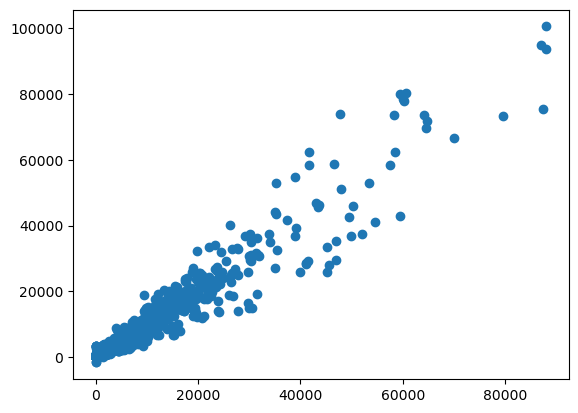

In [13]:
y_pred=X_test @ optimal_w
plt.plot(y_test, y_pred, 'o')

In [14]:
#Ensemble weights optimised wrt WIS with constraint sum(w)=1
def WIS_loss(w, X, Q, y):
    point_pred = X @ w
    wis=[]
    for i in range(X.shape[0]):
        row=Q.iloc[i]
        wis.append(WIS(point_pred[i],get_quantiles(w,row),y[i],alphas,weights))    
    return np.sum(wis)

In [15]:
def get_quantiles(w,row):
    q = [(0.0, 0.0)] * 11
    for i in range(len(list_of_models)):
        q = q + w[i]*np.array(row.iloc[i])
    return [tuple(row) for row in q]

In [16]:
def get_median_quantiles(row):
    q = np.zeros((11,2,len(list_of_models)))
    for i in range(len(list_of_models)):
        q[:,:,i] = np.array(row.iloc[i])
    mq=np.median(q,axis=2)
    return [tuple(row) for row in mq]

In [17]:
# Define constraints and bounds
constraints = {'type': 'eq', 'fun': constraint}  # Equality constraint
bounds = [(0, None) for _ in range(X_train.shape[1])]  # Optional: Non-negative weights
# Initial guess
#initial_w = np.ones(X_train.shape[1]) / X_train.shape[1]  # Start with equal weights
initial_w = EnsW4
#initial_w = np.ones(X_train.shape[1]) / X_train.shape[1]  # Start with equal weights
print(initial_w)

[4.38378070e-10 2.03135054e-01 8.52810624e-02 3.66700845e-10
 2.89453015e-03 1.84289361e-01 1.25913236e-09 9.49692287e-10
 1.63614116e-02 2.03536011e-01 2.44016491e-10 7.18982863e-10
 2.20464222e-10 3.04502566e-01]


In [209]:
result = minimize(
    WIS_loss, 
    initial_w, 
    args=(X_train, quant_train, y_train), 
    constraints=constraints, 
    bounds=bounds,  # Use this if coefficients must also be non-negative
    method='trust-constr',
    #options = {'disp': True}
    options={'verbose': 3,'xtol': 1e-5,'barrier_tol': 1e-5}
)
# Extract the optimal coefficients
optimal_w = result.x
print(optimal_w,np.sum(optimal_w))
EnsW5=optimal_w.copy()
Inter5=0

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  15   |   0   | +1.6894e+16 | 1.00e+00 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  30   |   1   | +1.6894e+16 | 1.00e-01 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  45   |   2   | +1.6894e+16 | 1.00e-02 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   4   |  60   |   3   | +1.6894e+16 | 1.00e-03 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |  75   |   4   | +1.6894e+16 | 1.09e-04 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   6   |  90   |   5   | +1.6894e+16 | 1.21e-05 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   7   |  105  |   6   | +1.6894e+16 | 1.34e-06 | 3.21e+25 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   8   |  120  |   6   | +1.6894e+16 | 1.00e+

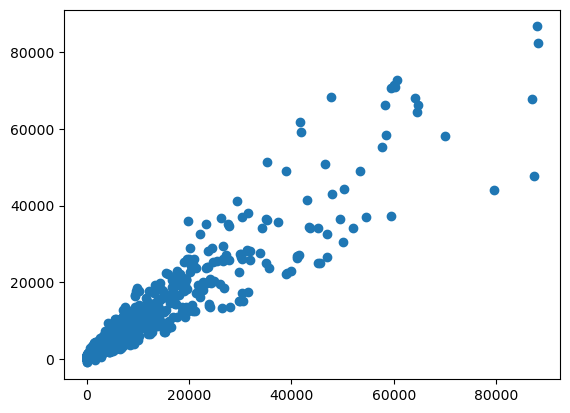

In [18]:
EnsW5 = np.array([
    5.04934334e-02, 2.13393611e-01, 3.93579881e-13, 5.34458293e-11,
    2.11851090e-05, 7.92148390e-02, 8.41197960e-03, 1.24978107e-01,
    1.72881968e-02, 2.55651612e-01, 2.10544472e-15, 7.30780345e-02,
    1.36975342e-07, 1.77468865e-01
])
Inter5=0
y_pred=X_test @ EnsW5
plt.plot(y_test, y_pred, 'o')

In [19]:
#Ensemble based on rank
model_ranks=pd.read_csv('./ranks_for_ensemble_wis_14.csv')
EnsW6=model_ranks.iloc[0,1:]
print(model_ranks)

               Unnamed: 0  Moving Average     ARIMA  Exponential  \
0                     all        0.000000  0.196295          0.0   
1  very high transmission        0.000000  0.000000          0.0   
2       high transmission        0.000000  0.174950          0.0   
3                  stable        0.173603  0.218481          0.0   
4        low transmission        0.000000  0.000000          0.0   
5    minimal transmission        0.000000  0.000000          0.0   

   Linear Regression  Bayesian Regression     SIRH1     SIRH2     SIRH3  \
0           0.000000             0.000000  0.000000  0.162409  0.201741   
1           0.000000             0.192934  0.128898  0.000000  0.139779   
2           0.129155             0.160986  0.000000  0.000000  0.000000   
3           0.000000             0.000000  0.000000  0.000000  0.205161   
4           0.000000             0.000000  0.244221  0.168852  0.212421   
5           0.000000             0.000000  0.165360  0.184925  0.190679  

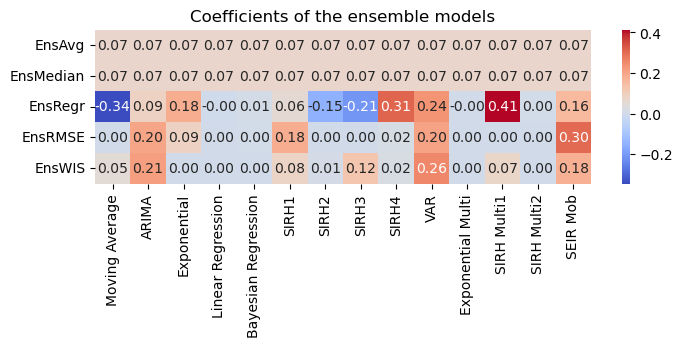

In [21]:
#Collect all ensemble weights
ens_weights=pd.DataFrame(columns=list_of_models)
ens_weights.loc[ens_names[0]]=EnsW1
ens_weights.loc[ens_names[1]]=EnsW2
ens_weights.loc[ens_names[2]]=EnsW3
ens_weights.loc[ens_names[3]]=EnsW4
ens_weights.loc[ens_names[4]]=EnsW5
#ens_weights.loc[ens_names[5]]=model_ranks.iloc[0,1:]

ens_names_short=ens_names.copy()
ens_names_short.remove('EnsRank')
ens_weights.to_csv('ensemble_weights.csv')
plt.figure(figsize=(8,2))
sns.heatmap(ens_weights, annot=True, cmap='coolwarm', fmt=".2f")
# centrer  les couleurs en zéro : zero = blanc  :
plt.yticks(ticks = [i+0.5 for i in range(len(ens_names_short))], labels=ens_names_short, rotation=0)
plt.title('Coefficients of the ensemble models')
plt.savefig('ens_weights.pdf', bbox_inches='tight')

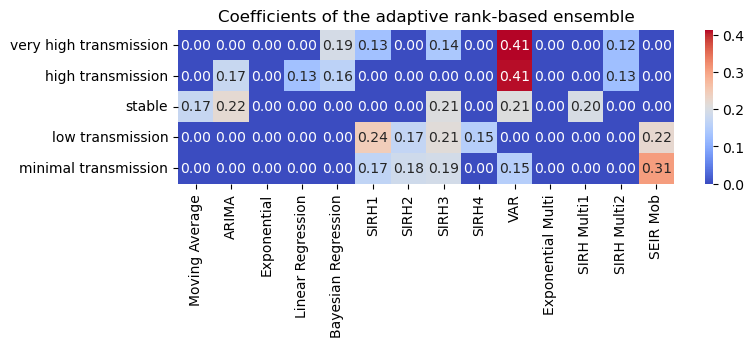

In [22]:
model_ranksp=pd.read_csv('./ranks_for_ensemble_wis_14.csv')
model_ranksp.drop(index=0, inplace=True)
point_types=model_ranksp['Unnamed: 0']
model_ranksp.drop(['Unnamed: 0'], axis=1, inplace=True)
plt.figure(figsize=(8,2))
sns.heatmap(model_ranksp, annot=True, cmap='coolwarm', fmt=".2f")
plt.yticks(ticks = [i+0.5 for i in range(len(point_types))], labels=point_types, rotation=0)
plt.title('Coefficients of the adaptive rank-based ensemble')
plt.savefig('ens_weights_rank.pdf', bbox_inches='tight')

In [23]:
def is_in_test_set(name): 
    for elt in names_test: 
        if str(name.split('_')[-5] ) + '_' + str(name.split('_')[-4]) in elt : 
            return True
    return False 

In [37]:
test_w = np.zeros((len(models1Dnames+models3Dnames)))
test_w[1]=1
loss='RMSE'
reach='14'
list_of_models_ens= models1Dnames+models3Dnames+ens_names
type_of_points=['all','very high transmission', 'high transmission' , 'stable',  'low transmission', 'minimal transmission']
rmse=np.zeros(len(list_of_models_ens))
k=0

for loss in ['RMSE']: #'WIS' 
    for reach in ['14']: #'14'
        df_expected_ranks=pd.DataFrame(columns= list_of_models_ens, index = type_of_points )
        df_expected_ranks_ens=pd.DataFrame(columns= ens_names, index = type_of_points )
        
        for numeropoint, label_point in enumerate(type_of_points):
            all_ranks=np.zeros((len(list_of_models_ens), len(list_of_models_ens)))
            for name in names_test:
                mob=name.split('_')[5]
                pand=(name.split('_')[6])
                pand=pand.split('.')[0]
                eval_name='evaluation_with_'+loss+'_of_1D_models_on_pandemic_'+mob+'_'+pand+'_and_reach_='+reach+'.json'
                with open('./results/global_evaluation/'+eval_name, 'r') as f:
                    dicoresults1 = json.load(f)
                with open('./results/global_evaluation/'+eval_name.replace('1D', '3D'), 'r') as f:
                    dicoresults2 = json.load(f)
                dicoresults=concat_dico(dicoresults1, dicoresults2)
                df=pd.read_csv('./all_pandemics/pandemic_'+mob+'_'+pand+'.csv')
                df.index=['n_hospitalized', 'n_infectious', 'mobility', 'r_eff']
                df.drop(['Unnamed: 0'], axis=1, inplace=True)
                n_hospitalized = np.array(df.loc['n_hospitalized'])
                r_eff=np.array(df.loc['r_eff'])
                indexs_points=[[20*i] for i in range(1, 15) ] 
                prediction=pd.read_csv('./results/predictions_of_the_models/predictions_'+str(reach)+'_days_on_pandemic_'+mob+'_'+pand+'.csv')
                prediction.drop(['Unnamed: 0'], axis=1, inplace=True)
                real_values=np.array(prediction['Real values'])
                prediction.drop(['Real values'],axis=1, inplace=True)
                prediction.index=[20*i for i in range(1,15)]
                prediction_all=prediction
                for i, point in enumerate(indexs_points): 
                    if n_hospitalized[point[0]] >= 10:
                        if label_point=='all':
                            pred_ens1=np.mean(prediction.iloc[i])
                            pred_ens2=np.median(prediction.iloc[i])
                            pred_ens3=np.dot(prediction.iloc[i],EnsW3)+Inter3
                            pred_ens4=np.dot(prediction.iloc[i],EnsW4) #EnsW4
                            pred_ens5=np.dot(prediction.iloc[i],EnsW5)
                            pred_ens6=np.dot(prediction.iloc[i],EnsW6)
                            ens_pred=np.array([pred_ens1,pred_ens2,pred_ens3,pred_ens4,pred_ens5,pred_ens6])
                            real_value=real_values[i]
                            ens_perf = np.sqrt((ens_pred - real_value) ** 2)                          
                            perfs=dicoresults[str(point)]
                            perfs.extend(ens_perf)
                            #print(perfs[1],perfs[-1])
                            rankings=get_classement(perfs)
                            #print(rankings)
                            k=k+1
                            for i in range(len(rankings)): 
                                rank_model_i=rankings[i]
                                all_ranks[i][rank_model_i]+=1
                                rmse[i]=rmse[i]+perfs[i]

                        elif classify_bis(point[0], r_eff) == label_point :
                            pred_ens1=np.mean(prediction.iloc[i])
                            pred_ens2=np.median(prediction.iloc[i])
                            pred_ens3=np.dot(prediction.iloc[i],EnsW3)+Inter3
                            pred_ens4=np.dot(prediction.iloc[i],EnsW4)
                            pred_ens5=np.dot(prediction.iloc[i],EnsW5)
                            pred_ens6=np.dot(prediction.iloc[i],model_ranks.iloc[numeropoint,1:])
                            ens_pred=np.array([pred_ens1,pred_ens2,pred_ens3,pred_ens4,pred_ens5,pred_ens6])
                            
                            real_value=real_values[i]
                            ens_perf = np.sqrt((ens_pred - real_value) ** 2)                          
                            perfs=dicoresults[str(point)]
                            perfs.extend(ens_perf)
                            rankings=get_classement(perfs)
                            for i in range(len(rankings)): 
                                rank_model_i=rankings[i]
                                all_ranks[i][rank_model_i]+=1
            expected_ranks=[np.sum((np.array(all_ranks[i])/np.sum(np.array(all_ranks[i])))*np.array([i for i in range( len(rankings))])) for i in range(len(rankings))]    
            df_expected_ranks.loc[label_point]=expected_ranks#[14:]
            df_expected_ranks_ens.loc[label_point]=expected_ranks[14:]
print(rmse/k)
                   

[3.50143538e+03 1.61298155e+03 5.17005200e+03 1.35019769e+10
 1.50129711e+04 2.21853791e+03 2.18887796e+03 2.24527732e+03
 2.02966788e+03 1.95674136e+03 9.81587036e+16 2.91551503e+03
 7.77306205e+03 1.57189254e+03 7.01133694e+15 1.61196994e+03
 9.28991897e+13 2.39534562e+07 1.52592162e+03 1.24719107e+03]


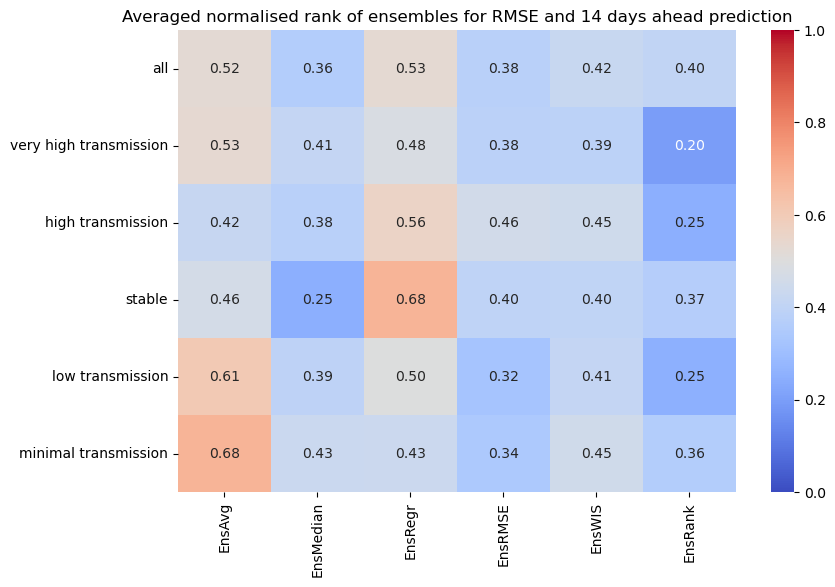

In [38]:
plt.figure(figsize=(9,6))
sns.heatmap(df_expected_ranks_ens.astype(float)/len(list_of_models_ens), cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
xticks = ens_names #list_of_models_ens
yticks = type_of_points
plt.xticks(ticks=[i+0.5 for i in range(len(xticks))], labels=xticks, rotation=90)
plt.yticks(ticks=[i+0.5 for i in range(len(yticks))], labels=yticks, rotation=0)
plt.title('Averaged normalised rank of ensembles for '+str(loss)+' and '+str(reach)+' days ahead prediction')
plt.savefig('heatmap_ens_rmse.pdf', bbox_inches='tight')

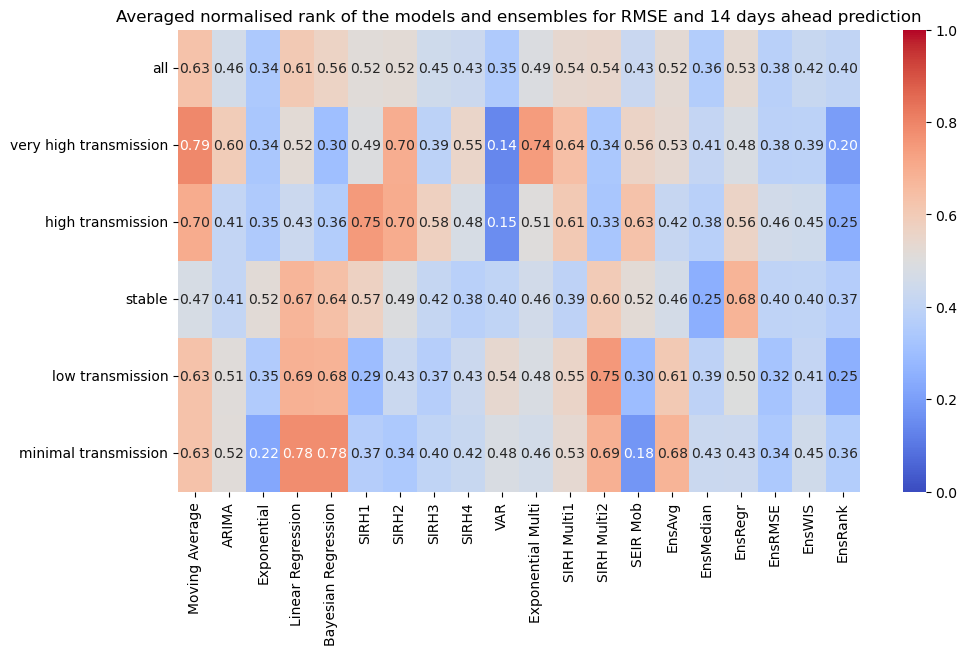

In [39]:
plt.figure(figsize=(11,6))
sns.heatmap(df_expected_ranks.astype(float)/len(list_of_models_ens), cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
xticks = list_of_models_ens#ens_names
yticks = type_of_points
plt.xticks(ticks=[i+0.5 for i in range(len(xticks))], labels=xticks, rotation=90)
plt.yticks(ticks=[i+0.5 for i in range(len(yticks))], labels=yticks, rotation=0)
plt.title('Averaged normalised rank of the models and ensembles for '+str(loss)+' and '+str(reach)+' days ahead prediction')
plt.savefig('heatmap_ens_rmse_all.pdf', bbox_inches='tight')

In [40]:
test_w = np.zeros((len(models1Dnames+models3Dnames)))
test_w[1]=1
loss='WIS'
reach='14'
list_of_models_ens= models1Dnames+models3Dnames+ens_names
type_of_points=['all','very high transmission', 'high transmission' , 'stable',  'low transmission', 'minimal transmission']
wis=np.zeros(len(list_of_models_ens))
npoints=np.zeros(len(type_of_points))
k=0
for loss in ['WIS']: #'WIS' 
    for reach in ['14']: #'14'
        df_expected_ranks_ens=pd.DataFrame(columns= ens_names, index = type_of_points )
        df_expected_ranks=pd.DataFrame(columns= list_of_models_ens, index = type_of_points )

        for numeropoint,label_point in enumerate(type_of_points):

            all_ranks=np.zeros((len(list_of_models_ens), len(list_of_models_ens)))
            for name_i,name in enumerate(names_test):
                mob=name.split('_')[5]
                pand=(name.split('_')[6])
                pand=pand.split('.')[0]
                eval_name='evaluation_with_'+loss+'_of_1D_models_on_pandemic_'+mob+'_'+pand+'_and_reach_='+reach+'.json'
                with open('./results/global_evaluation/'+eval_name, 'r') as f:
                    dicoresults1 = json.load(f)
                with open('./results/global_evaluation/'+eval_name.replace('1D', '3D'), 'r') as f:
                    dicoresults2 = json.load(f)
                dicoresults=concat_dico(dicoresults1, dicoresults2)
                df=pd.read_csv('./all_pandemics/pandemic_'+mob+'_'+pand+'.csv')
                df.index=['n_hospitalized', 'n_infectious', 'mobility', 'r_eff']
                df.drop(['Unnamed: 0'], axis=1, inplace=True)
                n_hospitalized = np.array(df.loc['n_hospitalized'])
                r_eff=np.array(df.loc['r_eff'])
                indexs_points=[[20*i] for i in range(1, 15)] 
                prediction=pd.read_csv('./results/predictions_of_the_models/predictions_'+str(reach)+'_days_on_pandemic_'+mob+'_'+pand+'.csv')
                prediction.drop(['Unnamed: 0'], axis=1, inplace=True)
                real_values=np.array(prediction['Real values'])
                prediction.drop(['Real values'],axis=1, inplace=True)
                prediction.index=[20*i for i in range(1,15)]
                prediction_all=prediction
                for i, point in enumerate(indexs_points): 
                    if n_hospitalized[point[0]] >= 10:
                        if label_point=='all':
                            npoints[numeropoint]=npoints[numeropoint]+1
                            real_value=real_values[i]
                            
                            pred_ens1=np.mean(prediction.iloc[i])
                            pred_ens2=np.median(prediction.iloc[i])
                            pred_ens3=np.dot(prediction.iloc[i],EnsW3)+Inter3
                            pred_ens4=np.dot(prediction.iloc[i],EnsW4) #EnsW4
                            pred_ens5=np.dot(prediction.iloc[i],EnsW5)
                            pred_ens6=np.dot(prediction.iloc[i],EnsW6)
                            
                            ens_pred=np.array([pred_ens1,pred_ens2,pred_ens3,pred_ens4,pred_ens5,pred_ens6])

                            inds=np.arange(14*name_i,14*name_i+14)
                            point_quants=quant_test.iloc[inds]
                            quant_ens1=get_quantiles(EnsW1,point_quants.iloc[i])
                            quant_ens2=get_median_quantiles(point_quants.iloc[i])
                            quant_ens3=get_quantiles(EnsW3,point_quants.iloc[i])
                            quant_ens3 = [(x + Inter3, y + Inter3) for x, y in quant_ens3]
                            quant_ens4=get_quantiles(EnsW4,point_quants.iloc[i])
                            quant_ens5=get_quantiles(EnsW5,point_quants.iloc[i])
                            quant_ens6=get_quantiles(EnsW6,point_quants.iloc[i])

                            wis_ens1=WIS(real_value,quant_ens1,pred_ens1,alphas,weights)
                            wis_ens2=WIS(real_value,quant_ens2,pred_ens2,alphas,weights)
                            wis_ens3=WIS(real_value,quant_ens3,pred_ens3,alphas,weights)
                            wis_ens4=WIS(real_value,quant_ens4,pred_ens4,alphas,weights)
                            wis_ens5=WIS(real_value,quant_ens5,pred_ens5,alphas,weights)
                            wis_ens6=WIS(real_value,quant_ens6,pred_ens6,alphas,weights)
                            
                            ens_perf = np.array([wis_ens1,wis_ens2,wis_ens3,wis_ens4,wis_ens5,wis_ens6])                         
                            perfs=dicoresults[str(point)]
                            perfs.extend(ens_perf)
                            #rankings=get_classement(perfs)
                            rankings = rankdata(perfs, method='ordinal')-1
                            k=k+1
                            for ii in range(len(rankings)): 
                                rank_model_i=rankings[ii]
                                all_ranks[ii][rank_model_i]+=1
                                wis[ii]=wis[ii]+perfs[ii]
                            
                        elif classify_bis(point[0], r_eff) == label_point:
                            npoints[numeropoint]=npoints[numeropoint]+1
                            real_value=real_values[i]
                            
                            pred_ens1=np.mean(prediction.iloc[i])
                            pred_ens2=np.median(prediction.iloc[i])
                            pred_ens3=np.dot(prediction.iloc[i],EnsW3)+Inter3
                            pred_ens4=np.dot(prediction.iloc[i],EnsW4) #EnsW4
                            pred_ens5=np.dot(prediction.iloc[i],EnsW5)
                            pred_ens6=np.dot(prediction.iloc[i],model_ranks.iloc[numeropoint,1:])
                            
                            ens_pred=np.array([pred_ens1,pred_ens2,pred_ens3,pred_ens4,pred_ens5,pred_ens6])

                            inds=np.arange(14*name_i,14*name_i+14)
                            point_quants=quant_test.iloc[inds]
                            quant_ens1=get_quantiles(EnsW1,point_quants.iloc[i])
                            quant_ens2=get_median_quantiles(point_quants.iloc[i])
                            quant_ens3=get_quantiles(EnsW3,point_quants.iloc[i])
                            quant_ens3 = [(x + Inter3, y + Inter3) for x, y in quant_ens3]
                            quant_ens4=get_quantiles(EnsW4,point_quants.iloc[i])
                            quant_ens5=get_quantiles(EnsW5,point_quants.iloc[i])
                            quant_ens6=get_quantiles(model_ranks.iloc[numeropoint,1:],point_quants.iloc[i])

                            wis_ens1=WIS(real_value,quant_ens1,pred_ens1,alphas,weights)
                            wis_ens2=WIS(real_value,quant_ens2,pred_ens2,alphas,weights)
                            wis_ens3=WIS(real_value,quant_ens3,pred_ens3,alphas,weights)
                            wis_ens4=WIS(real_value,quant_ens4,pred_ens4,alphas,weights)
                            wis_ens5=WIS(real_value,quant_ens5,pred_ens5,alphas,weights)
                            wis_ens6=WIS(real_value,quant_ens6,pred_ens6,alphas,weights)
                            
                            ens_perf = np.array([wis_ens1,wis_ens2,wis_ens3,wis_ens4,wis_ens5,wis_ens6])                         
                            perfs=dicoresults[str(point)]
                            perfs.extend(ens_perf)
                            #rankings=get_classement(perfs)
                            rankings = rankdata(perfs, method='ordinal')-1
                            for ii in range(len(rankings)): 
                                rank_model_i=rankings[ii]
                                all_ranks[ii][rank_model_i]+=1

            #print(label_point,all_ranks)
            expected_ranks=[np.sum((np.array(all_ranks[i])/np.sum(np.array(all_ranks[i])))*np.array([i for i in range( len(rankings))])) for i in range(len(rankings))]    
            df_expected_ranks.loc[label_point]=expected_ranks
            df_expected_ranks_ens.loc[label_point]=expected_ranks[14:]

print(wis/k)           

/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q = q + w[i]*np.array(row.iloc[i])
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q = q + w[i]*np.array(row.iloc[i])
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

[3.17106889e+03 1.27937185e+03 3.05919843e+05 1.23960902e+10
 1.47583059e+04 2.08817295e+03 1.84221782e+03 1.75116429e+03
 4.59628201e+03 1.78558739e+03            inf 2.91255804e+03
 4.13398533e+04 1.48413112e+03 4.01190523e+16 3.73741210e+02
 4.23617521e+15 1.37082026e+08 1.43183208e+03 1.99502653e+02]


/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q = q + w[i]*np.array(row.iloc[i])
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q = q + w[i]*np.array(row.iloc[i])
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_72041/1508672954.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

In [41]:
#Correct 'all'-value for EnsRank
avgr=0
for i in range(1,len(npoints)):
    avgr=avgr+df_expected_ranks['EnsRank'].iloc[i]*npoints[i]
    print(i)
avg_rank=avgr/np.sum(npoints[1:])
df_expected_ranks_ens.iat[0,5]=avg_rank
df_expected_ranks.iat[0,19]=avg_rank

1
2
3
4
5


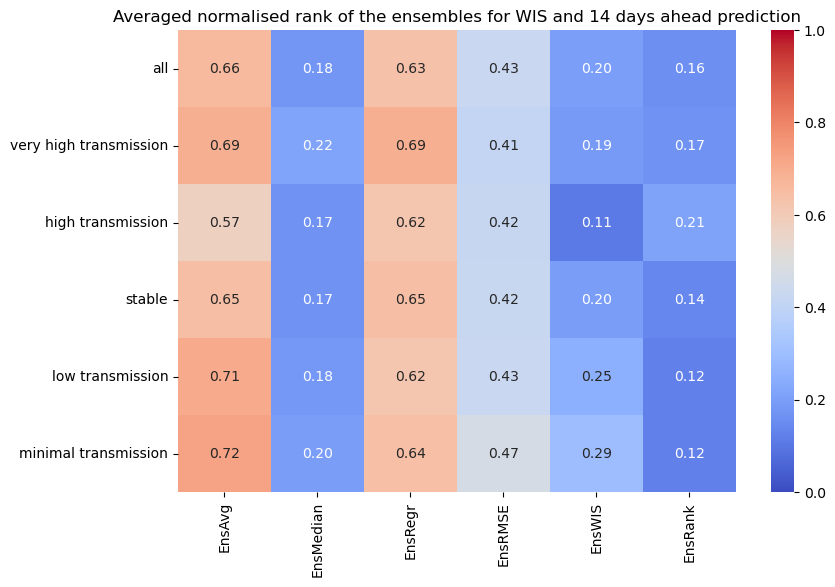

In [42]:
plt.figure(figsize=(9,6))
sns.heatmap(df_expected_ranks_ens.astype(float)/len(list_of_models_ens), cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
xticks = ens_names #list_of_models_ens
yticks = type_of_points
plt.xticks(ticks=[i+0.5 for i in range(len(xticks))], labels=xticks, rotation=90)
plt.yticks(ticks=[i+0.5 for i in range(len(yticks))], labels=yticks, rotation=0)
plt.title('Averaged normalised rank of the ensembles for '+str(loss)+' and '+str(reach)+' days ahead prediction')
plt.savefig('heatmap_ens_wis.pdf', bbox_inches='tight')

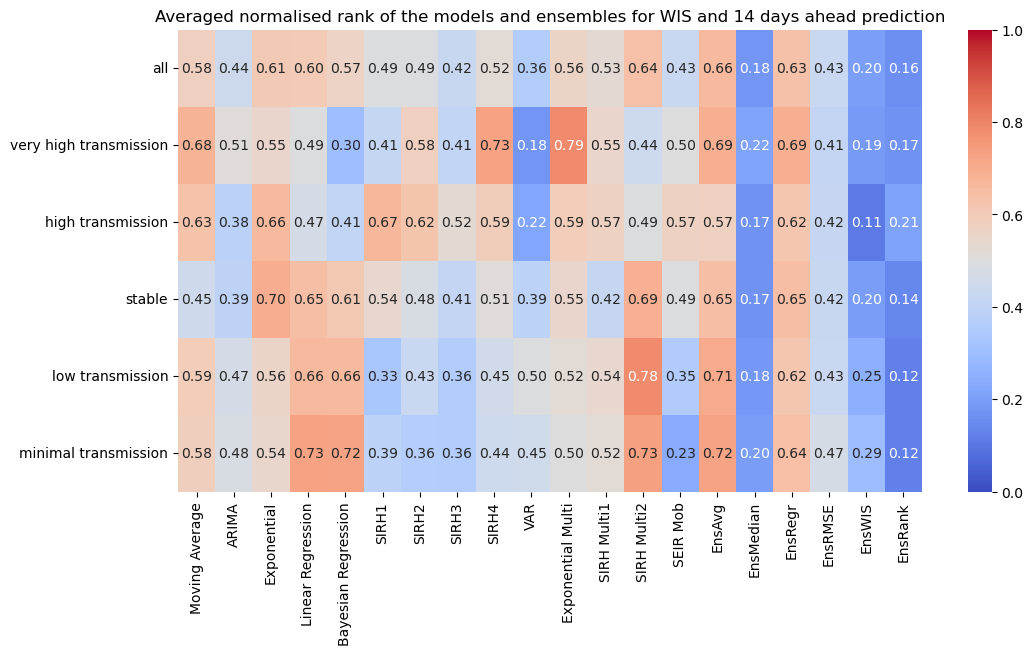

In [43]:
plt.figure(figsize=(12,6))
sns.heatmap(df_expected_ranks.astype(float)/len(list_of_models_ens), cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
xticks = list_of_models_ens
yticks = type_of_points
plt.xticks(ticks=[i+0.5 for i in range(len(xticks))], labels=xticks, rotation=90)
plt.yticks(ticks=[i+0.5 for i in range(len(yticks))], labels=yticks, rotation=0)
plt.title('Averaged normalised rank of the models and ensembles for '+str(loss)+' and '+str(reach)+' days ahead prediction')
plt.savefig('heatmap_ens_wis_all.pdf', bbox_inches='tight')